In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile, Aer
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
from qiskit.transpiler.passes import RemoveBarriers

In [3]:
# Import QREM package
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.ignis.mitigation import expectation_value

/var/folders/vr/d82vcp297v78vk4sb0_nzzdc0000gn/T/ipykernel_54787/3056705909.py:2: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [4]:
# Import mitiq for zne
# unused for this file
import mitiq

In [5]:
# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [6]:
import sys
import importlib
sys.path.append("../../solutions/utils/")
import circuit_utils, zne_utils, tomography_utils
importlib.reload(circuit_utils)
importlib.reload(zne_utils) # unused for this file
importlib.reload(tomography_utils) # unused for this file
from circuit_utils import *
from zne_utils import zne_wrapper, zne_decoder
from tomography_utils import expvals_to_valid_rho

In [7]:
from qiskit.test.mock import FakeJakarta
backend = FakeJakarta()
# backend = Aer.get_backend("qasm_simulator")

In [8]:
num_qubits = 3

# The final time of the state evolution
target_time = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# Convert custom quantum circuit into a gate
trot_gate = trotter_gate(dt)

# initial layout
initial_layout = [5,3,1]

# Number of trotter steps
num_steps_list = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
print("trotter step list: ", num_steps_list)

scale_factors = [1.0, 2.0, 3.0] # unused for this file

shots = 1 << 13
reps = 8 # unused

target_state = (One^One^Zero).to_matrix() # DO NOT CHANGE!!!

trotter step list:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [9]:
# QREM
qr = QuantumRegister(num_qubits, name="calq")
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
# we have to feed initial_layout to calibration matrix
cal_job = execute(meas_calibs, backend=backend, shots=shots, optimization_level=3, initial_layout = initial_layout)
print('Job ID', cal_job.job_id())

retrieved_cal_job = cal_job
cal_results = retrieved_cal_job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

Job ID e3140522-e317-4409-840a-c9f7158b1d16


In [10]:
zne_fid_list = []
zne_stddev_list = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qr = QuantumRegister(num_qubits, name="q")
    qc = QuantumCircuit(qr)

    # Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
    make_initial_state(qc, "110")  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

    subspace_encoder_init110(qc, targets=[0, 1, 2]) # encode
    trotterize(qc, trot_gate, num_steps, targets=[1, 2]) # Simulate time evolution under H_heis3 Hamiltonian
    subspace_decoder(qc, targets=[0, 1, 2]) # decode

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.bind_parameters({dt: target_time / num_steps})
    print("created qc")

    # Generate state tomography circuits to evaluate fidelity of simulation
    st_qcs = state_tomography_circuits(qc, [0, 1, 2][::-1])  #! state tomography requires === BIG ENDIAN === 
    print("created st_qcs (length:", len(st_qcs), ")")

    # remove barriers
    st_qcs = [RemoveBarriers()(qc) for qc in st_qcs]
    print("removed barriers from st_qcs")

    # optimize circuit
    t3_st_qcs = transpile(st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
    t3_st_qcs = transpile(t3_st_qcs, optimization_level=3, basis_gates=["sx", "cx", "rz"])
    print("created t3_st_qcs (length:", len(t3_st_qcs), ")")

    # zne wrapping
    zne_qcs = t3_st_qcs
    zne_qcs = zne_wrapper(t3_st_qcs, scale_factors = scale_factors, pt = False)
    print("created zne_qcs (length:", len(zne_qcs), ")")

    # optimization_level must be 0
    # feed initial_layout here to see the picture of the circuits before casting the job
    t3_zne_qcs = transpile(zne_qcs, optimization_level=0, basis_gates=["sx", "cx", "rz"], initial_layout=initial_layout)
    print("created t3_zne_qcs (length:", len(t3_zne_qcs), ")")
    
    jobs = []
    for _ in range(reps):
        #! CHECK: run t3_zne_qcs, with optimization_level = 0 and straightforward initial_layout
        job = execute(t3_zne_qcs, backend, shots=shots, optimization_level=0)
        print('Job ID', job.job_id())
        jobs.append(job)
    
    retrieved_jobs = jobs
    zne_fids = []
    for job in retrieved_jobs:
        raw_results = job.result()
        mit_results = meas_fitter.filter.apply(raw_results)
        zne_expvals = zne_decoder(num_qubits, mit_results, scale_factors = scale_factors)
        zne_rho = expvals_to_valid_rho(num_qubits, zne_expvals)
        zne_fid = state_fidelity(zne_rho, target_state)
        zne_fids.append(zne_fid)
        
    zne_fid_list.append(np.mean(zne_fids))
    zne_stddev_list.append(np.std(zne_fids))
    
    t2 = time.perf_counter()
    print('zne state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(zne_fids), np.std(zne_fids)))
    print("time:", t2 - t1)
    print()

trotter steps:  1
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created zne_qcs (length: 81 )
created t3_zne_qcs (length: 81 )
Job ID 25ca0dcc-ae7b-4991-84c5-bda035874e4d
Job ID 72e3f650-e6d0-4bec-b485-4cf7a37f0dda
Job ID 171a8fcb-b905-4dcd-89e9-2df32d9597c4
Job ID b7816a24-bc6b-4e0f-b304-72c733cc75f4
Job ID 58c09da4-e353-4178-bdeb-dfdabb58f4b9
Job ID 47819626-377e-443b-9c47-f3c08824e00d
Job ID 9dd5cc1d-b409-4cde-9143-09a1f117bdfb
Job ID c9e08fbf-3663-477f-bfa7-6c25a4d7b769
zne state tomography fidelity = 0.9775 ± 0.0080
time: 56.906392814

trotter steps:  2
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created zne_qcs (length: 81 )
created t3_zne_qcs (length: 81 )
Job ID d0081917-cdd8-43b3-ab8e-52cef819eb2e
Job ID 090f82fc-951c-4c55-bf47-39c09e58a3d6
Job ID 20ee5403-1819-4c28-a9b3-466c1ad981ba
Job ID efe6e5ea-232c-4090-a674-1741e28e13cb
Job ID 8f03201d-f607-4982-8d90-13ef6e7ff

Job ID bbad1abf-e733-48a6-8bba-bc15c14926f2
Job ID 2cc2dc43-8620-4e00-b887-70916d515288
Job ID 12791a8b-7a94-4900-b054-50d92fbcdd44
Job ID cb6484e4-6538-49e1-b62c-5c08872e373f
Job ID c0c49459-b094-4d63-87b5-57b73a990ebe
zne state tomography fidelity = 0.9752 ± 0.0046
time: 58.71271552999997

trotter steps:  60
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_st_qcs (length: 27 )
created zne_qcs (length: 81 )
created t3_zne_qcs (length: 81 )
Job ID 1e0c96b1-eb8d-4b0c-92db-937a73e70dfe
Job ID a20544a4-cd67-4910-8d59-b42622604b0a
Job ID c17ccdfc-8e2d-4f9d-8e17-5c9e44376c9c
Job ID a1223a6e-145d-41b9-9f77-65332de19c92
Job ID 18263872-58fa-4f6e-97d5-0eac07844efe
Job ID 114c2889-3db6-4fb3-8751-b54236f1a056
Job ID ea239460-1514-428f-bf6c-3b68e5c520d3
Job ID a1f089d9-f767-4a1c-b3c5-1de0e31a060b
zne state tomography fidelity = 0.9868 ± 0.0043
time: 61.39060413200002

trotter steps:  70
created qc
created st_qcs (length: 27 )
removed barriers from st_qcs
created t3_

In [11]:
with open("e2d1_zne.pkl", "wb") as f:
    pickle.dump({"num_steps_list": num_steps_list, "fid": zne_fid_list, "stddev": zne_stddev_list}, f)

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table

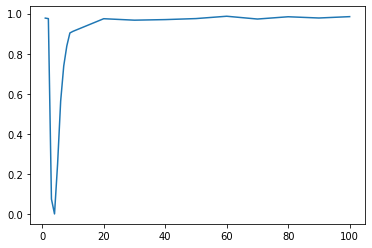

In [13]:
plt.plot(num_steps_list, zne_fid_list)